# Refactoring Code with Artifacts

LineaPy’s artifacts store the complete development history in intelligent graph representation, and this enables automatic transformation of the development code.

An important application of such transformation is “program slicing” where the development code is “sliced” to only retain minimal necessary operations generating the final state/object of interest (e.g., trained model).

Traditionally, a major bottleneck in any data science work is refactoring messy development code into clean, production-ready code, so LineaPy’s support for automatic code clean-up is likely to boost the productivity and impact of data science teams.

In this tutorial, we will walk through an example that illustrates how this can be done.

<div class="alert alert-info">

You can ignore `# NBVAL_*` comments in certain cell blocks. They are for passing unit tests only, which we do to make sure the examples are always functional as we update the codebase.

</div>

In [1]:
# NBVAL_IGNORE_OUTPUT

import os
import lineapy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

As part of a public health study, we were given a data set to explore. Let's see what it contains.

In [2]:
# Load data
df = pd.read_csv("data/biometrics.csv")

In [3]:
# View data
df

,name,gender,height,weight
0,John,M,183,85
1,Mary,F,175,70
2,Nick,M,170,63
3,Stacy,F,162,50
4,Tom,M,168,75
5,Ava,F,185,72


It is simple data that has individuals' height and weight information. Our common sense dictates that these two physical traits may have an association. Let's quickly check.

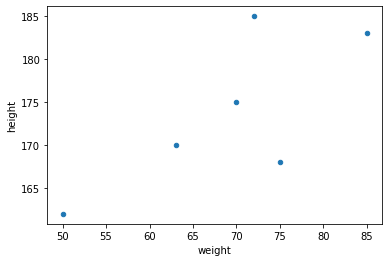

In [4]:
# Plot weight vs. height
df.plot.scatter("weight", "height")
plt.show()

The scatter plot suggests a linear relationship between weight and height.

Can we quantify this relationship? We can check correlation coefficient:

In [5]:
# Calculate correlation coefficient
df.corr(method="pearson")

,height,weight
height,1.000000,0.746616
weight,0.746616,1.000000


The value indicates a high correlation, which is not very surprising.

To make our analysis more interesting, let’s try some formal modeling. Given the linear-looking relationship in the scatter plot, we can use linear regression.

In [6]:
# Initiate the model
lm = LinearRegression()

In [7]:
# Fit the model
lm.fit(
    X=df[["height"]],
    y=df["weight"],
)

LinearRegression()

In [8]:
# NBVAL_IGNORE_OUTPUT

# Check result
print(f"Coefficient for height: {lm.coef_[0]}")

Coefficient for height: 0.9882992060175508


Result suggests that a unit increase in height is associated with about a unit increase in weight.

Now, we may wonder if gender plays any role in this. That is, given the same gender, how is change in height associated with change in weight?

To answer this question, we can include the gender term in our regression model. But we need to first pre-process the data. Specifically, `gender` needs to be transformed into a numeric variable so that the model can use it. Let's code male as `0` and female as `1`.

In [9]:
# Create a numeric variable encoding gender
df["gender_numeric"] = df["gender"].map({"M": 0, "F": 1})

In [10]:
# View data
df

,name,gender,height,weight,gender_numeric
0,John,M,183,85,0
1,Mary,F,175,70,1
2,Nick,M,170,63,0
3,Stacy,F,162,50,1
4,Tom,M,168,75,0
5,Ava,F,185,72,1


And we retrain the model using the new gender term:

In [11]:
# Refit the model
lm.fit(
    X=df[["height", "gender_numeric"]],
    y=df["weight"],
)

LinearRegression()

In [12]:
# NBVAL_IGNORE_OUTPUT

# Check result
print(f"Coefficient for height: {lm.coef_[0]}")
print(f"Coefficient for gender: {lm.coef_[1]}")

Coefficient for height: 1.0016722408026753
Coefficient for gender: -10.667224080267554


Result is similar to what we observed before, i.e. a unit increase in height is associated with about a unit increase in weight. Interestingly, we also see the gender difference in weight quantified: controlling for height, females tend to be about 10 units lighter than males.

Maybe gender plays a role in a different way: it may mediate the strength of the association between height and weight. For instance, height may more strongly relate with weight among males (than among females). To examine this possibility, we can introduce an interaction term.

In [13]:
# Create an gender interaction term
df["gender_height"] = df["gender_numeric"] * df["height"]

In [14]:
# Refit the model
lm.fit(
    X=df[["height", "gender_numeric", "gender_height"]],
    y=df["weight"],
)

LinearRegression()

In [15]:
# NBVAL_IGNORE_OUTPUT

# Check result
print(f"Coefficient for height: {lm.coef_[0]}")
print(f"Coefficient for gender: {lm.coef_[1]}")
print(f"Coefficient for gender-height interaction: {lm.coef_[2]}")

Coefficient for height: 1.035175879396986
Coefficient for gender: -1.9412475913398337
Coefficient for gender-height interaction: -0.0502134733819492


We see that the interaction coefficient is not very large but, given the reduction in gender coefficient, we can see that the gender difference we observed earlier is largely attributable to interaction. We also confirm that a unit increase in height is still associated with about a unit increase in weight &mdash; after controlling for interaction.

Now, we are ready to wrap up our analysis. Say we decided that we would later revisit our final model. We can then store it as an artifact, like so:

In [16]:
# Save model as an artifact
artifact = lineapy.save(lm, "linear_model")

If we print the artifact’s code, we get:

In [17]:
print(artifact.get_code())

import pandas as pd
from sklearn.linear_model import LinearRegression
df = pd.read_csv("data/biometrics.csv")
lm = LinearRegression()
lm.fit(
    X=df[["height"]],
    y=df["weight"],
)
df["gender_numeric"] = df["gender"].map({"M": 0, "F": 1})
lm.fit(
    X=df[["height", "gender_numeric"]],
    y=df["weight"],
)
df["gender_height"] = df["gender_numeric"] * df["height"]
lm.fit(
    X=df[["height", "gender_numeric", "gender_height"]],
    y=df["weight"],
)



which is much more concise and manageable than what we have generated &mdash; a long, messy collection of various operations.

Note that actual development scripts/notebooks by data scientists are much longer and more complicated than the current example. Hence, LineaPy's automatic code refactoring can save considerable time for data scientists and production engineers.